In [1]:
# DERIVE THE EOMs SYMBOLICALLY ----------------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# create symbolic variables

# generalized coordinates
x  ,  dx,  ddx = sym.symbols(['x'          ,'\dot{x}'          ,'\ddot{x}'])
y  ,  dy,  ddy = sym.symbols(['y'          ,'\dot{y}'          ,'\ddot{y}'])
th1,dth1,ddth1 = sym.symbols(['\\theta_{1}','\dot{\\theta}_{1}','\ddot{\\theta}_{1}'])
th2,dth2,ddth2 = sym.symbols(['\\theta_{2}','\dot{\\theta}_{2}','\ddot{\\theta}_{2}'])
th3,dth3,ddth3 = sym.symbols(['\\theta_{3}','\dot{\\theta}_{3}','\ddot{\\theta}_{3}'])
#th4,dth4,ddth4 = sym.symbols(['\\theta_{4}','\dot{\\theta}_{4}','\ddot{\\theta}_{4}'])

# system parameters
g = sym.symbols('g')
m1, l1, In1 = sym.symbols(['m_{1}','l_{1}','I_{1}'])
m2, l2, In2 = sym.symbols(['m_{2}','l_{2}','I_{2}'])
m3, l3, In3 = sym.symbols(['m_{3}','l_{3}','I_{3}'])
#m4, l4, In4 = sym.symbols(['m_{4}','l_{4}','I_{4}'])

q   = sym.Matrix([  [x],  [y],  [th1],  [th2],  [th3]])
dq  = sym.Matrix([ [dx], [dy], [dth1], [dth2], [dth3]])
ddq = sym.Matrix([[ddx],[ddy],[ddth1],[ddth2],[ddth3]])

#q   = sym.Matrix([  [x],  [y],  [th1],  [th2],  [th3],  [th4]])
#dq  = sym.Matrix([ [dx], [dy], [dth1], [dth2], [dth3], [dth4]])
#ddq = sym.Matrix([[ddx],[ddy],[ddth1],[ddth2],[ddth3],[ddth4]])

# functions, # don't ask, they work for the purposes of this program
def WeirdRot(v, th):
    # weird rotation function for working with [x; y; th] vectors
    # usage: it is an R_1^0 matrix, and stores the angle of rotation in result
    R = sym.Matrix([[sym.cos(th), -sym.sin(th), 0],
                    [sym.sin(th),  sym.cos(th), 0],
                   [       0,        0, 1]])
    S = sym.Matrix([[0],[0],[th]])
    return R*v + S

def WeirdAdd(v1, v2):
    # returns the sum of two vectors of the form [x; y; th]
    # both in the same ref frame, preserving only the first angle
    v3 = sym.Matrix([[1],[1],[0]])
    return v1 + sym.matrix_multiply_elementwise(v3, v2)

def WeirdTrans(v1, ang1, off1, ang2=0, off2=sym.Matrix([[0],[0],[0]])):
    # ^ & ^ just like me
    # transforms [x,y,th] vector to inertial frame
    rn_m = WeirdAdd(WeirdRot(v1, ang1),off1)
    rn_0 = WeirdAdd(WeirdRot(rn_m, ang2),off2)
    return rn_0

# mass positions
r1_1 = sym.Matrix([[0],[0],[0]])
r1_0 = WeirdTrans(r1_1, th1, sym.Matrix([[x],[y],[0]]))

r2_2 = sym.Matrix([[0],[-l2/2],[0]])
r2_0 = WeirdTrans(r2_2, th1+th2, r1_0)

r3_3 = sym.Matrix([[0],[-l3/2],[0]])
r3_0 = WeirdTrans(r3_3, th3, r2_2, th1+th2, r2_0)

#r4_4 = sym.Matrix([[0],[l4/2],[0]])
#r4_0 = WeirdTrans(r4_4, th4, r3_3, th1+th2+th3, r3_0)

# mass velocities
dr1 = r1_0.jacobian(q)*dq
dr2 = r2_0.jacobian(q)*dq
dr3 = r3_0.jacobian(q)*dq
#dr4 = r4_0.jacobian(q)*dq

# kinetic and potential energy
def Ek(m, In, dr):
    return 0.5*sym.Matrix([[m, m, In]])*dr

def Ep(m, r):
    return sym.Matrix([m*g*r[1]])

T = Ek(m1,In1,dr1) + Ek(m2,In2,dr2) + Ek(m3,In3,dr3)
#T = T[0]
#display(T)
V = Ep(m1,r1_0) + Ep(m2,r2_0) + Ep(m3,r3_0)

# Mass, Gravity, Coriolis matrices
LgM = sym.hessian(T, dq)
LgG = V.jacobian(q)

M_col = LgM.reshape(LgM.rows * LgM.cols, 1)
dM = M_col.jacobian(q)*dq
dM = dM.reshape(LgM.rows, LgM.cols)
Tj = T.jacobian(q)
LgC = dM*dq - Tj.T

# forces
tau1, tau2, GRFx, GRFy = sym.symbols(['\\tau_{1}','\\tau_{2}','G_x','G_y'])

tau1_l1 = sym.Matrix([[0],[0],[-tau1]])
tau1_l2 = sym.Matrix([[0],[0], [tau1]])
tau2_l2 = sym.Matrix([[0],[0],[-tau2]])
tau2_l3 = sym.Matrix([[0],[0], [tau2]])

# tau3_l3 = sym.Matrix([[0],[0],[-tau3]])
# tau3_l4 = sym.Matrix([[0],[0], [tau3]])

GRF_l3 = sym.Matrix([[GRFx],[GRFy],[0.5*l3*GRFx*sym.cos(th1+th2+th3)+0.5*l3*GRFy*sym.sin(th1+th2+th3)]])

def Qterm(F,r):
    Q = F.T * r.jacobian(q)
    return Q.T

Qtau1 = Qterm(tau1_l1, r1_0) + Qterm(tau1_l2, r2_0)
Qtau2 = Qterm(tau2_l2, r2_0) + Qterm(tau2_l3, r3_0)
QGRF = Qterm(GRF_l3, r3_0)

Qtot = QGRF + Qtau1 + Qtau2
#MATLAB VER:
#function Q = Qterm(F,r,q)
#%Function to make Qmatrix code more readable
#Q = transpose(transpose(F) ∗ jacobian(r,q));
#end
EOM = LgM*ddq + LgC + LgG.T - Qtot
display(sym.simplify(EOM))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                               Gₓ⋅(2⋅l_{2}⋅co
⎢     -0.5⋅Gₓ⋅l_{3}⋅cos(\theta_{1} + \theta_{2} + \theta_{3}) - ──────────────
⎢                                                                             
⎢                                                                             
⎢                                                          Gₓ⋅(2⋅l_{2}⋅cos(\th
⎢-0.5⋅Gₓ⋅l_{3}⋅cos(\theta_{1} + \theta_{2} + \theta_{3}) - ───────────────────
⎢                                                                             
⎢                                                                             
⎢                                                   

In [2]:
# Lambdify
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,
            m1,l1,In1,
            m2,l2,In2,
            m3,l3,In3,
            x,dx,ddx,
            y,dy,ddy,
            th1,dth1,ddth1,
            th2,dth2,ddth2,
            th3,dth3,ddth3,
            #th4,dth4,ddth4,
            tau1,tau2,#tau3,
            GRFx,GRFy]

lambEOM = {}

DOFs = ['x','y','th1','th2','th3']

for dof_i, dof in enumerate(DOFs):
    lambEOM[dof] = sym.lambdify(sym_list,EOM[dof_i],modules = [func_map])

In [3]:
TDOFs = ['x','y'] # translational DOFs - i.e. the ones that the foot has

# foot position
pfoot = WeirdTrans(2*r3_3, th3, r2_2, th1+th2, r2_0)
# foot velocity
vfoot = pfoot.jacobian(q)*dq

lamb_pfoot = {}
lamb_vfoot = {}

for dof_i, dof in enumerate(TDOFs):
    lamb_pfoot[dof] = sym.lambdify(sym_list,pfoot[dof_i],modules = [func_map])
    lamb_vfoot[dof] = sym.lambdify(sym_list,vfoot[dof_i],modules = [func_map])

# PYOMO

In [4]:
# import libraries
# Pyomo stuff
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import numpy as np

from IPython.display import display #for pretty printing

# create the model
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

# for sprint task
N = 100 

# for sanity checks
# N = 20
m.N = RangeSet(N) 

# sets can have multidimensional indices
# (probably a little gratuitous for such a simple model, but thought I'd show you anyway)
links = [('body',1),('leg',1),('leg',2)]
m.L = Set(dimen=2, initialize = links)

m.DOF = Set(initialize = DOFs) # the coordinates for each link
m.TDOF = Set(initialize = TDOFs) # world-frame coordinates for contact variables

In [5]:
# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81)

# whenever a multidimensional set is passed to a function, the index is expanded (infuriatingly enough...)
# so every function indexed on L needs to expect two inputs from that set 
# I've called them l = [lb, ln] for 'branch' and 'number'

def get_m(n, lb, ln):
    if lb == 'body':
        return 0.5
    else: return 0.25
# note that the masses add up to 1
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ln):
    if lb == 'body':
        return 1.0
    else: return 0.5
m.len = Param(m.L, initialize = get_len) # length of links

def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function.
    return m.m[l]*m.len[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# joint forces
joints = ['hip','knee']
m.J = Set(initialize = joints)
m.fj = Var(m.N, m.J) # net force at each joint

# ground reaction forces
m.GRF = Var(m.N, m.TDOF)

# bound variables
for n in range(1,N+1):
    for l in links:
        m.q[n,'y'].setlb(0.0)
        m.q[n,'th1'].setlb(-0.5*np.pi)
        m.q[n,'th1'].setub(0.5*np.pi)
        m.q[n,'th2'].setlb(-0.5*np.pi)
        m.q[n,'th2'].setub(0.5*np.pi)
        m.q[n,'th3'].setlb(-0.5*np.pi)
        m.q[n,'th3'].setub(0.5*np.pi)
        
    m.fj[n,'hip'].setlb(-2)
    m.fj[n,'hip'].setub(2)
    m.fj[n,'knee'].setlb(-10)
    m.fj[n,'knee'].setub(10)
        
    m.GRF[n,'y'].setlb(0)

In [6]:
# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.0))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n-1,dof]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

# Equations of motion -----------------------------------------------------

# if you have a bunch of lambdify functions, it's helpful to create a function to deliver the list of variables each time
def get_var_list(m,n):
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'x'],m.q[n,'y'],m.q[n,'th1'],m.q[n,'th2'],m.q[n,'th3'],
                m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'th1'],m.dq[n,'th2'],m.dq[n,'th3'],
                m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'th1'],m.ddq[n,'th2'],m.ddq[n,'th3'],
                m.fj[n,'knee'],m.fj[n,'hip'],m.GRF[n,'x'],m.GRF[n,'y']]
    return var_list

def dynamics(m,n,dof):
    var_list = get_var_list(m,n)
    return lambEOM[dof](*var_list) == 0
m.dynamics = Constraint(m.N, m.DOF, rule = dynamics)

In [7]:
# GROUND INTERACTIONS -------------------------------------------------------------------------------------------------------

# paramters
m.mu = Param(initialize = 0.5) # friction coefficient

# sign set for positive and negative components
signs = ['ps','ng'] 
m.sgn = Set(initialize = signs)

# variables
# (I had that set error while trying to set up these default bounds. That's why I pointed it out.)

m.footy = Var(m.N, bounds = (0.0,None)) # foot position
m.footdx = Var(m.N, m.sgn, bounds = (0.0,None)) # foot velocity

m.friction_cone = Var(m.N, bounds = (0.0,None))

m.Gx = Var(m.N, m.sgn, bounds = (0.0,None)) # signed components of friction force

ground_constraints = ['contact','friction','slip_ps','slip_ng'] 
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

# constraints: aux variables

def def_footy(m,n):
    var_list = get_var_list(m,n)
    return m.footy[n] == lamb_pfoot['y'](*var_list)
m.def_footy = Constraint(m.N, rule = def_footy)

def def_footdx(m,n):
    var_list = get_var_list(m,n)
    return m.footdx[n,'ps'] - m.footdx[n,'ng'] == lamb_vfoot['x'](*var_list)
m.def_footdx = Constraint(m.N, rule = def_footdx)

def get_Gx(m,n):
    return m.GRF[n,'x'] == m.Gx[n,'ps'] - m.Gx[n,'ng']
m.get_Gx = Constraint(m.N, rule = get_Gx)

def def_friction_cone(m,n):
    return m.friction_cone[n] == m.mu*m.GRF[n,'y'] - (m.Gx[n,'ps'] + m.Gx[n,'ng'])
m.def_friction_cone = Constraint(m.N, rule = def_friction_cone)

# constraints: complementarity

# contact
def ground_contact(m,n):
    if n < N:
        return m.footy[n+1]*m.GRF[n,'y']  <= m.ground_penalty[n,'contact']
        # notice that the GRF is complemented with the foot height at the NEXT node
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, rule = ground_contact)

# friction
def ground_friction(m,n):
    return (m.footdx[n,'ps']+m.footdx[n,'ng'])*m.friction_cone[n] <= m.ground_penalty[n,'friction'] 
m.ground_friction = Constraint(m.N, rule = ground_friction)

# slipping
def ground_slip_ps(m,n):
    return m.footdx[n,'ps']*m.Gx[n,'ps'] <= m.ground_penalty[n,'slip_ps']
m.ground_slip_ps = Constraint(m.N, rule = ground_slip_ps)

def ground_slip_ng(m,n):
    return m.footdx[n,'ng']*m.Gx[n,'ng'] <= m.ground_penalty[n,'slip_ng']
m.ground_slip_ng = Constraint(m.N, rule = ground_slip_ng)

In [17]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------

# minimum time

def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))
    penalty_sum = sum([m.ground_penalty[n,gc] for n in range(1,N+1) for gc in ground_constraints])
    # ain't single-line for loops grand?
    return T+1000*penalty_sum

    #return penalty_sum # for sanity checks
m.Cost = Objective(rule = CostFun)

    'pyomo.core.base.objective.SimpleObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.SimpleObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


In [18]:
# HIGH DROP -----------------------------------------------------------------------------------------------------------------

# initial condition
for dof in DOFs:
    m.dq[1,dof].fix(0) # rest
    if dof != 'y':
        m.q[1,dof].fix(0) # neutral posture
m.footy[1].fix(100)

for n in range(1,N+1):
    for j in joints:
        m.fj[n,j].fix(0) # no forces

In [19]:
def init_opt(): # initializes solver
    opt = SolverFactory('ipopt')
    opt.options["linear_solver"] = 'ma97'
    opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
    opt.options["max_iter"] = 30000 # maximum number of iterations
    opt.options["max_cpu_time"] = 300 # maximum cpu time in seconds
    opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
    opt.options["OF_acceptable_obj_change_tol"] = 1e-4
    opt.options["OF_ma86_scaling"] = 'none'
    
    return opt

In [20]:
# if the problem is infeasible, this is how you can see which constraints weren't satisfied
from pyomo.util.infeasible import log_infeasible_constraints
log_infeasible_constraints(m)

INFO: CONSTR integrate_p[2,th2]: 0.3906826887768639 =/= 0.0
INFO: CONSTR def_footy[1]: 100.50519225393882 =/= 0.0


In [21]:
opt = init_opt()
results = opt.solve(m, tee = True)
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

penalty_sum = 0
for n in range(1,N+1):
    for gc in ground_constraints:
        penalty_sum += m.ground_penalty[n,gc].value
print(penalty_sum)

#m.pprint() 

Ipopt 3.13.4: linear_solver=ma97
print_level=5
max_iter=30000
max_cpu_time=300
Tol=1e-06
option_file_name=/tmp/tmpq59mig7v_ipopt.opt

Using option file "/tmp/tmpq59mig7v_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver ma97.

Number of nonzeros in equality constraint Jacobian...:     8625
Number of nonzeros in inequality constraint Jacobian.:     1297
Number of nonzeros in Lagrangian Hessian.............:     3568

Total number of variables............................:     2788
                     variables with only lower bounds:     1199
                variables with lower and uppe

    model=unknown;
        message from solver=Ipopt 3.13.4\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
warning
infeasible
2777.940511158014


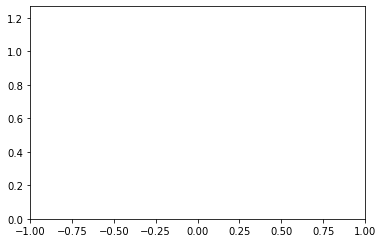

In [22]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

xmax = np.max([m.q[n,'x'].value for n in range(1,N+1)])
ymax = np.max([m.q[n,'y'].value for n in range(1,N+1)])

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,xmax+1]) # adjust limits to solution
    ax.set_ylim([0,ymax+0.5])
    
    #plot body
    body_xb = m.q[i,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'th1'].value)
    body_yb = m.q[i,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'th1'].value)
    body_xf = m.q[i,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'th1'].value)
    body_yf = m.q[i,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'th1'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
      
    #plot leg 1
    thA = m.q[i,'th1'].value+m.q[i,'th2'].value
    leg1_xt = m.q[i,'x'].value
    leg1_yt = m.q[i,'y'].value
    leg1_xb = m.q[i,'x'].value + m.len[('leg',1)]*sin(thA)
    leg1_yb = m.q[i,'y'].value - m.len[('leg',1)]*cos(thA)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:black')
    
    #plot leg 2
    thB = m.q[i,'th1'].value+m.q[i,'th2'].value+m.q[i,'th3'].value
    leg2_xt = leg1_xb
    leg2_yt = leg1_yb
    leg2_xb = leg1_xb + m.len[('leg',2)]*sin(thB)
    leg2_yb = leg1_yb - m.len[('leg',2)]*cos(thB)
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:black')
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [14]:
m.ddq.pprint()

ddq : Size=500, Index=ddq_index
    Key          : Lower : Value                   : Upper : Fixed : Stale : Domain
      (1, 'th1') :  None :    -0.07859813698258869 :  None : False : False :  Reals
      (1, 'th2') :  None :      104.56942602835365 :  None : False : False :  Reals
      (1, 'th3') :  None :       20.97753375700971 :  None : False : False :  Reals
        (1, 'x') :  None :   8.005029839937127e-12 :  None : False : False :  Reals
        (1, 'y') :  None :       13.54287337532707 :  None : False : False :  Reals
      (2, 'th1') :  None :     -0.6056124325910771 :  None : False : False :  Reals
      (2, 'th2') :  None :       38.92446580090177 :  None : False : False :  Reals
      (2, 'th3') :  None :      0.1205030681566967 :  None : False : False :  Reals
        (2, 'x') :  None :     -171.97354832728396 :  None : False : False :  Reals
        (2, 'y') :  None :      -7.341702037999696 :  None : False : False :  Reals
      (3, 'th1') :  None :    -0.49717170615

In [15]:
m.dq.pprint()

dq : Size=500, Index=dq_index
    Key          : Lower : Value                   : Upper : Fixed : Stale : Domain
      (1, 'th1') :  None :                       0 :  None :  True :  True :  Reals
      (1, 'th2') :  None :                       0 :  None :  True :  True :  Reals
      (1, 'th3') :  None :                       0 :  None :  True :  True :  Reals
        (1, 'x') :  None :                       0 :  None :  True :  True :  Reals
        (1, 'y') :  None :                       0 :  None :  True :  True :  Reals
      (2, 'th1') :  None :  -0.0015719627137700258 :  None : False : False :  Reals
      (2, 'th2') :  None :      2.0913884860639813 :  None : False : False :  Reals
      (2, 'th3') :  None :      0.4195506682185766 :  None : False : False :  Reals
        (2, 'x') :  None :  2.1263674407845505e-13 :  None : False : False :  Reals
        (2, 'y') :  None :      0.2708574630380148 :  None : False : False :  Reals
      (3, 'th1') :  None :   -0.01368421102718

In [16]:
m.q.pprint()

q : Size=500, Index=q_index
    Key          : Lower               : Value                   : Upper              : Fixed : Stale : Domain
      (1, 'th1') : -1.5707963267948966 :                       0 : 1.5707963267948966 :  True :  True :  Reals
      (1, 'th2') : -1.5707963267948966 :                       0 : 1.5707963267948966 :  True :  True :  Reals
      (1, 'th3') : -1.5707963267948966 :                       0 : 1.5707963267948966 :  True :  True :  Reals
        (1, 'x') :                None :                       0 :               None :  True :  True :  Reals
        (1, 'y') :                 0.0 :      1.4503818213107973 :               None : False : False :  Reals
      (2, 'th1') : -1.5707963267948966 :   5.644472232651955e-17 : 1.5707963267948966 : False : False :  Reals
      (2, 'th2') : -1.5707963267948966 :      0.3906826887768639 : 1.5707963267948966 : False : False :  Reals
      (2, 'th3') : -1.5707963267948966 : -4.1666331950332275e-15 : 1.570796326794896

     (29, 'th2') : -1.5707963267948966 :      0.6676999472401942 : 1.5707963267948966 : False : False :  Reals
     (29, 'th3') : -1.5707963267948966 :      0.3469669502410172 : 1.5707963267948966 : False : False :  Reals
       (29, 'x') :                None :     -2.1839922812247745 :               None : False : False :  Reals
       (29, 'y') :                 0.0 :      1.1199128405341507 :               None : False : False :  Reals
     (30, 'th1') : -1.5707963267948966 :   -0.009655807501248262 : 1.5707963267948966 : False : False :  Reals
     (30, 'th2') : -1.5707963267948966 :      0.6614721703811487 : 1.5707963267948966 : False : False :  Reals
     (30, 'th3') : -1.5707963267948966 :      0.3626952198946033 : 1.5707963267948966 : False : False :  Reals
       (30, 'x') :                None :     -2.2531391598843697 :               None : False : False :  Reals
       (30, 'y') :                 0.0 :      1.1040558021921811 :               None : False : False :  Reals
 